In [2]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/331.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/331.8 MB 2.6 MB/s eta 0:02:10
   ---------------------------------------- 0.3/331.8 MB 3.9 MB/s eta 0:01:25
   ---------------------------------------- 0.4/331.8 MB 4.1 MB/s eta 0:01:21
   ---------------------------------------- 0.8/331.8 MB 5.0 MB/s eta 0:01:07
   ---------------------------------------- 0.8/331.8 MB 5.0 MB/s eta 0:01:07
   ---------------------------------------- 1.0/331.8 MB 3.8 MB/s eta 0:01:27
   ---------------------------------------- 1.2/331.8 MB 4.1 MB/s eta 0:01:22
   ---------------------------------------- 1.6/331.8 MB 4.5 MB/s eta 0:01:14
   ---------------------------------------- 1.8/331.8 MB 4.6 MB/s eta 0:01:13
   ---------------------------------------- 2.0/331.8 MB 4.6 MB/s eta 0:01:12
   ---------------------------------------- 2.3/331.8 MB 4.8 MB/s eta 0


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


--- 1. Generating Data ---
Full train set: (500, 2)
Train split: (400, 2)
Validation split: (100, 2)

--- 2.1. Training Model 1: MLP + Early Stopping ---
Best Val AUROC: 0.9364

--- 2.2. Training Model 2: MLP + L1 Grid Search ---
Validation AUROC vs. λ (L1):
  λ = 1e-06: Val AUROC = 0.9545
  λ = 3e-06: Val AUROC = 0.9364
  λ = 1e-05: Val AUROC = 0.9364
  λ = 3e-05: Val AUROC = 0.9364
  λ = 1e-04: Val AUROC = 0.9364
  λ = 3e-04: Val AUROC = 0.9364
Best L1 λ: 1e-06 with Val AUROC: 0.9545
Layer-wise Sparsity (L1, |w| < 1e-03):
  Hidden Layer (W1): 1.50% (3/200 weights)
  Output Layer (W2): 0.00% (0/100 weights)

--- 2.3. Training Model 3: MLP + L2 Grid Search ---
Validation AUROC vs. λ (L2):
  λ = 1e-06: Val AUROC = 0.9364
  λ = 3e-06: Val AUROC = 0.9364
  λ = 1e-05: Val AUROC = 0.9364
  λ = 3e-05: Val AUROC = 0.9364
  λ = 1e-04: Val AUROC = 0.9364
  λ = 3e-04: Val AUROC = 0.9364
  λ = 1e-03: Val AUROC = 0.9364
  λ = 1e-02: Val AUROC = 0.9384
Best L2 λ: 0.01 with Val AUROC: 0.9384

--- 2.

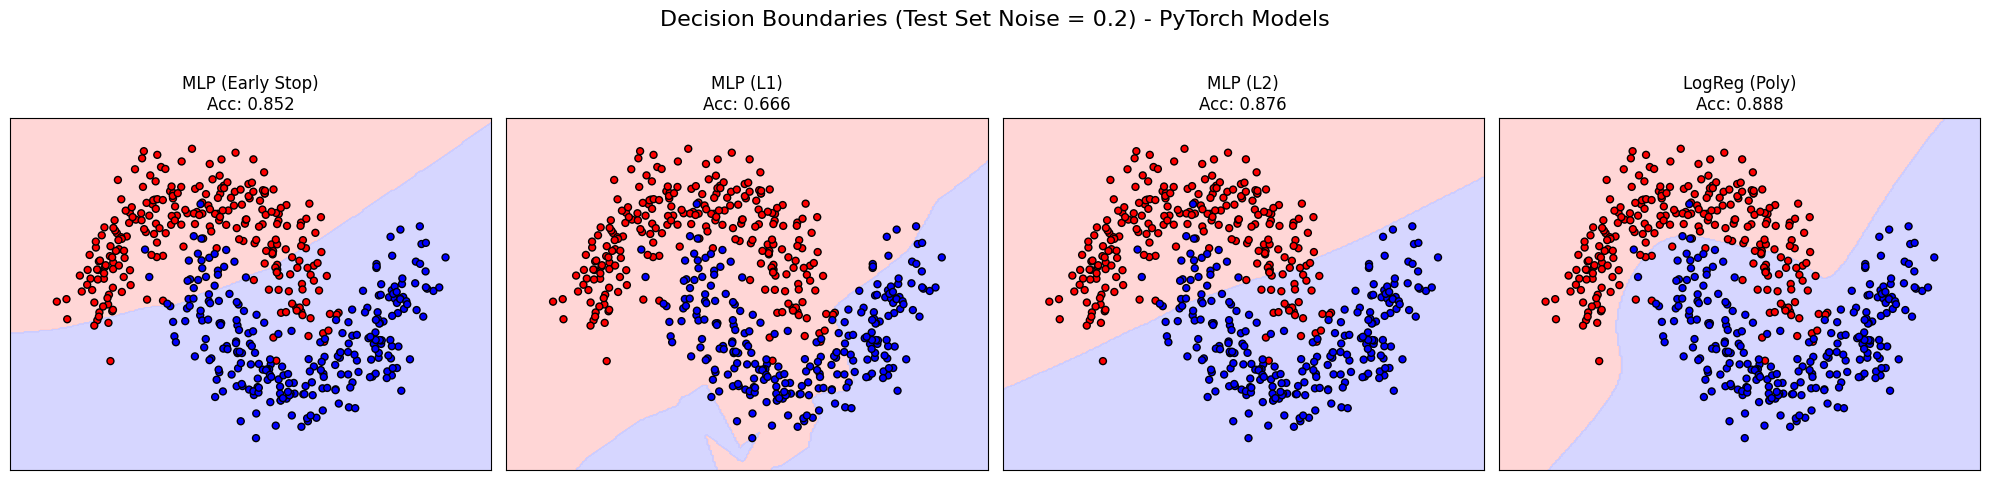


--- 3.3. Evaluating Class Imbalance (70:30) ---
Imbalanced train set shape: (291, 2)
Class 0 samples: 204 (70.1%)
Class 1 samples: 87 (29.9%)
Retraining models on imbalanced data...

--- Imbalance Model Performance (on Balanced Test Set) ---
Model              | Accuracy   | AUROC     
------------------------------------------
MLP (Early Stop)   | 0.5020     | 0.9407    
MLP (L1)           | 0.5380     | 0.9381    
MLP (L2)           | 0.7920     | 0.9308    
LogReg (Poly)      | 0.7980     | 0.9293    

--- PyTorch Script Finished ---


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils import resample
import copy

# --- PyTorch Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seed for reproducibility
RANDOM_SEED = 1337
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)


# 1. Data Generation (from original script)

def generate_moons(n_samples, noise=0.2, random_state=RANDOM_SEED):
    """Generates the moons dataset manually."""
    rng = np.random.RandomState(random_state)
    
    n_samples_half = n_samples // 2
    
    t = np.linspace(0, np.pi, n_samples_half)
    x1_upper = np.cos(t)
    y1_upper = np.sin(t)
    
    t = np.linspace(0, np.pi, n_samples_half)
    x1_lower = 1 - np.cos(t)
    y1_lower = 0.5 - np.sin(t)
    
    X = np.vstack([
        np.column_stack([x1_upper, y1_upper]),
        np.column_stack([x1_lower, y1_lower])
    ])
    y = np.hstack([np.zeros(n_samples_half), np.ones(n_samples_half)])
    
    X += rng.normal(scale=noise, size=X.shape)
    
    if n_samples % 2 != 0:
        t_extra = np.pi / 2
        x_extra = 1 - np.cos(t_extra) + rng.normal(scale=noise)
        y_extra = 0.5 - np.sin(t_extra) + rng.normal(scale=noise)
        X = np.vstack([X, [x_extra, y_extra]])
        y = np.hstack([y, [1]])
        
    return X, y

print("--- 1. Generating Data ---")
X_train_full, y_train_full = generate_moons(n_samples=500, noise=0.2, random_state=RANDOM_SEED)
X_test_02, y_test_02 = generate_moons(n_samples=500, noise=0.2, random_state=RANDOM_SEED + 1)
X_test_01, y_test_01 = generate_moons(n_samples=500, noise=0.1, random_state=RANDOM_SEED + 2)
X_test_03, y_test_03 = generate_moons(n_samples=500, noise=0.3, random_state=RANDOM_SEED + 4)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.20, random_state=RANDOM_SEED
)

print(f"Full train set: {X_train_full.shape}")
print(f"Train split: {X_train.shape}")
print(f"Validation split: {X_val.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_01_scaled = scaler.transform(X_test_01)
X_test_02_scaled = scaler.transform(X_test_02)
X_test_03_scaled = scaler.transform(X_test_03)

test_sets_np = {
    0.1: (X_test_01_scaled, y_test_01),
    0.2: (X_test_02_scaled, y_test_02),
    0.3: (X_test_03_scaled, y_test_03)
}


# 2. PyTorch Model Definitions & Training Loop


# --- PyTorch MLP Model (for Models 1, 2, 3) ---
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=100, output_dim=1):
        super(MLP, self).__init__()
        # Use nn.Sequential as shown in the reference
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        # Output logits
        return self.layers(x)

# --- PyTorch Logistic Regression Model (for Model 4) ---
class TorchLogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super(TorchLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        # Output logits
        return self.linear(x)

# --- Unified Training Function ---
def train_model(model, X_train_t, y_train_t, X_val_t, y_val_t, 
                lam_l1=0.0, lam_l2=0.0, 
                epochs=1000, patience=50, learning_rate=1e-3):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # BCEWithLogitsLoss is numerically stable and takes raw logits
    criterion = nn.BCEWithLogitsLoss() 
    
    best_val_auc = -1
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        
        # Forward pass
        y_pred_logits = model(X_train_t)
        loss = criterion(y_pred_logits, y_train_t)
        
        # Add L1 regularization (if specified)
        if lam_l1 > 0:
            l1_norm = 0
            # Apply L1 only to weights (layer 0 and 2), not biases
            for name, param in model.named_parameters():
                if 'weight' in name:
                    l1_norm += torch.norm(param, 1)
            loss += lam_l1 * l1_norm

         # Add manual L2 regularization (if specified)
        if lam_l2 > 0:
            l2_norm = 0
            for name, param in model.named_parameters():
                if 'weight' in name:
                    l2_norm += torch.norm(param, 2) ** 2
            loss += lam_l2 * l2_norm

        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_logits = model(X_val_t)
            # Use validation data to check for early stopping
            val_probs = torch.sigmoid(val_logits)
            # We use roc_auc_score from sklearn, so convert back to numpy
            val_auc = roc_auc_score(y_val_t.cpu().numpy(), val_probs.cpu().numpy())
        
        # Early stopping logic (based on validation AUROC)
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            # Save the best model state
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            # print(f"Early stopping at epoch {epoch} with Val AUROC: {best_val_auc:.4f}")
            break
    
    # Restore the best model found
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model, best_val_auc

# --- Wrapper Classes (for sklearn compatibility) ---
class PyTorchWrapper:
    """Wraps a PyTorch model to mimic sklearn's .predict() and .predict_proba()"""
    def __init__(self, model):
        self.model = model
        self.model.eval()
    
    def predict_proba(self, X_numpy):
        # Convert numpy array to tensor
        X_t = torch.tensor(X_numpy, dtype=torch.float32)
        with torch.no_grad():
            logits = self.model(X_t)
            probs_class_1 = torch.sigmoid(logits).cpu().numpy()
        probs_class_0 = 1 - probs_class_1
        return np.hstack([probs_class_0, probs_class_1]) # sklearn format [P(0), P(1)]

    def predict(self, X_numpy):
        probs = self.predict_proba(X_numpy)
        return (probs[:, 1] > 0.5).astype(int)
    
    def get_params(self, deep=False): # For plotting compatibility
        return {'model': self.model}

class PyTorchPolyLogRegWrapper(PyTorchWrapper):
    """Special wrapper for Model 4 that includes the polynomial transform"""
    def __init__(self, poly_transformer, model):
        super().__init__(model)
        self.poly = poly_transformer
    
    def predict_proba(self, X_numpy):
        # 1. Apply polynomial features
        X_poly_numpy = self.poly.transform(X_numpy)
        # 2. Call the parent's (PyTorchWrapper) predict_proba
        return super().predict_proba(X_poly_numpy)

# --- Convert all data to Tensors ---
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# Keep test sets as numpy for the sklearn-based eval loop
test_sets = test_sets_np

models = {}
model_accuracies = {}
model_params = {}

# ---
# 3. Model Training
# ---

# Model 1: MLP with Early Stopping (PyTorch)
print("\n--- 2.1. Training Model 1: MLP + Early Stopping ---")
model_1 = MLP(input_dim=2, hidden_dim=100)
mlp_early_stop, val_auc_1 = train_model(
    model_1, X_train_t, y_train_t, X_val_t, y_val_t, 
    patience=50
)
models['MLP (Early Stop)'] = PyTorchWrapper(mlp_early_stop)
print(f"Best Val AUROC: {val_auc_1:.4f}")
# Count parameters
params_1 = sum(p.numel() for p in mlp_early_stop.parameters() if p.requires_grad)
model_params['MLP (Early Stop)'] = params_1


# Model 2: MLP with L1 Regularization (PyTorch)
print("\n--- 2.2. Training Model 2: MLP + L1 Grid Search ---")
l1_lambdas = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
best_l1_auc = -1
best_l1_model = None
best_l1_lambda = None

print("Validation AUROC vs. \u03BB (L1):")
for lam in l1_lambdas:
    model_l1 = MLP(input_dim=2, hidden_dim=100)
    # Reset seeds for fair comparison
    torch.manual_seed(RANDOM_SEED)
    
    model_l1, val_auc = train_model(
        model_l1, X_train_t, y_train_t, X_val_t, y_val_t,
        lam_l1=lam, patience=50
    )
    print(f"  \u03BB = {lam:.0e}: Val AUROC = {val_auc:.4f}")
    
    if val_auc > best_l1_auc:
        best_l1_auc = val_auc
        best_l1_model = model_l1
        best_l1_lambda = lam

models['MLP (L1)'] = PyTorchWrapper(best_l1_model)
params_2 = sum(p.numel() for p in best_l1_model.parameters() if p.requires_grad)
model_params['MLP (L1)'] = params_2
print(f"Best L1 \u03BB: {best_l1_lambda} with Val AUROC: {best_l1_auc:.4f}")

# Report Layerwise Sparsity
# We check for weights *very close* to zero, as L1 penalty 
sparsity_threshold = 1e-3
w1 = best_l1_model.layers[0].weight.data
w2 = best_l1_model.layers[2].weight.data
sparsity_h = torch.sum(torch.abs(w1) < sparsity_threshold) / w1.numel()
sparsity_o = torch.sum(torch.abs(w2) < sparsity_threshold) / w2.numel()
print(f"Layer-wise Sparsity (L1, |w| < {sparsity_threshold:.0e}):")
print(f"  Hidden Layer (W1): {sparsity_h*100:.2f}% ({torch.sum(torch.abs(w1) < sparsity_threshold)}/{w1.numel()} weights)")
print(f"  Output Layer (W2): {sparsity_o*100:.2f}% ({torch.sum(torch.abs(w2) < sparsity_threshold)}/{w2.numel()} weights)")


# Model 3: MLP with L2 Regularization (PyTorch)
print("\n--- 2.3. Training Model 3: MLP + L2 Grid Search ---")
l2_lambdas = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 1e-2]
best_l2_auc = -1
best_l2_model = None
best_l2_lambda = None

print("Validation AUROC vs. \u03BB (L2):")
for lam in l2_lambdas:
    model_l2 = MLP(input_dim=2, hidden_dim=100)
    torch.manual_seed(RANDOM_SEED)
    
    model_l2, val_auc = train_model(
        model_l2, X_train_t, y_train_t, X_val_t, y_val_t,
        lam_l2=lam, patience=50 
    )
    print(f"  \u03BB = {lam:.0e}: Val AUROC = {val_auc:.4f}")
    
    if val_auc > best_l2_auc:
        best_l2_auc = val_auc
        best_l2_model = model_l2
        best_l2_lambda = lam

models['MLP (L2)'] = PyTorchWrapper(best_l2_model)
params_3 = sum(p.numel() for p in best_l2_model.parameters() if p.requires_grad)
model_params['MLP (L2)'] = params_3
print(f"Best L2 \u03BB: {best_l2_lambda} with Val AUROC: {best_l2_auc:.4f}")


# Model 4: Logistic Regression with Polynomial Features
print("\n--- 2.4. Training Model 4: Logistic Regression + Poly Features ---")
best_poly_auc = -1
best_poly_transformer = None
best_poly_model = None
best_poly_degree = -1

for degree in [2, 3, 4, 5]:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    # Fit on numpy data
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_val_poly = poly.transform(X_val_scaled)
    
    # Convert to Tensors
    X_train_poly_t = torch.tensor(X_train_poly, dtype=torch.float32)
    X_val_poly_t = torch.tensor(X_val_poly, dtype=torch.float32)
    
    n_features = X_train_poly_t.shape[1]
    
    model_4 = TorchLogisticRegression(input_dim=n_features)
    torch.manual_seed(RANDOM_SEED)
    
    log_reg_model, val_auc = train_model(
        model_4, X_train_poly_t, y_train_t, X_val_poly_t, y_val_t,
        patience=50
    )
    print(f"  Degree = {degree}: Val AUROC = {val_auc:.4f}")
    
    if val_auc > best_poly_auc:
        best_poly_auc = val_auc
        best_poly_transformer = poly
        best_poly_model = log_reg_model
        best_poly_degree = degree

# Use the special wrapper for this model
models['LogReg (Poly)'] = PyTorchPolyLogRegWrapper(best_poly_transformer, best_poly_model)
params_4 = sum(p.numel() for p in best_poly_model.parameters() if p.requires_grad)
model_params['LogReg (Poly)'] = params_4
print(f"Best Poly Degree: {best_poly_degree} with Val AUROC: {best_poly_auc:.4f}")



# 4. Evaluation and Analysis

print("\n--- 3.1. Evaluating Test Accuracy ---")
# This evaluation loop works as-is because our wrappers mimic sklearn
for model_name, model in models.items():
    if model is None: 
        model_accuracies[model_name] = {0.1: 0, 0.2: 0, 0.3: 0}
        continue
    accuracies = {}
    for noise_level, (X_test, y_test) in test_sets.items():
        y_pred = model.predict(X_test) # X_test is numpy
        acc = accuracy_score(y_test, y_pred)
        accuracies[noise_level] = acc
    model_accuracies[model_name] = accuracies

# Create the table
print("\n--- Accuracy & Robustness Table ---")
print(f"{'Model':<18} | {'Param Count':<12} | {'Test Acc (0.10)':<17} | {'Test Acc (0.20)':<17} | {'Test Acc (0.30)':<17}")
print("-" * 86)
for model_name, accuracies in model_accuracies.items():
    params = model_params[model_name]
    acc_01 = accuracies[0.1]
    acc_02 = accuracies[0.2]
    acc_03 = accuracies[0.3]
    if params == 0:
        print(f"{model_name:<18} | {'SKIPPED':<12} | {'N/A':<17} | {'N/A':<17} | {'N/A':<17}")
    else:
        print(f"{model_name:<18} | {params:<12} | {acc_01:<17.4f} | {acc_02:<17.4f} | {acc_03:<17.4f}")



# 5. Plot Decision Boundaries (on noise 0.2 test set)

print("\n--- 3.2. Plotting Decision Boundaries ---")
# This plotting code works as-is because our wrappers mimic sklearn
X_plot, y_plot = X_test_02_scaled, y_test_02
x_min, x_max = X_plot[:, 0].min() - 0.5, X_plot[:, 0].max() + 0.5
y_min, y_max = X_plot[:, 1].min() - 0.5, X_plot[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

grid_to_predict = np.c_[xx.ravel(), yy.ravel()]
cm_bright = ListedColormap(['#FF0000','#0000FF']) # Red/Blue
cm_map = ListedColormap(['#FFCCCC', '#CCCCFF']) # Light Red/Blue

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle("Decision Boundaries (Test Set Noise = 0.2) - PyTorch Models", fontsize=16)

valid_models = {k: v for k, v in models.items() if v is not None}

for ax, (model_name, model) in zip(axes, valid_models.items()):
    # .predict() takes numpy, which grid_to_predict is
    Z = model.predict(grid_to_predict) 
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, cmap=cm_map, alpha=0.8)
    ax.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, cmap=cm_bright,
               edgecolors='k', s=25)
    
    ax.set_title(f"{model_name}\nAcc: {model_accuracies[model_name][0.2]:.3f}")
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig("decision_boundaries_pytorch.png")
# print("Decision boundary plot saved as 'decision_boundaries_pytorch.png'")
plt.show()



# 6. Class Imbalance (70:30)

print("\n--- 3.3. Evaluating Class Imbalance (70:30) ---")

# Resample using numpy (from original script)
X_train_c0 = X_train_scaled[y_train == 0]
y_train_c0 = y_train[y_train == 0]
X_train_c1 = X_train_scaled[y_train == 1]
y_train_c1 = y_train[y_train == 1]

n_class_0 = len(y_train_c0)
n_class_1_new = int(n_class_0 * 0.3 / 0.7) 

X_train_c1_res, y_train_c1_res = resample(
    X_train_c1, y_train_c1, 
    n_samples=n_class_1_new, 
    random_state=RANDOM_SEED, 
    replace=False
)

X_train_imb = np.vstack([X_train_c0, X_train_c1_res])
y_train_imb = np.hstack([y_train_c0, y_train_c1_res])

print(f"Imbalanced train set shape: {X_train_imb.shape}")
print(f"Class 0 samples: {np.sum(y_train_imb == 0)} ({(np.sum(y_train_imb == 0)/len(y_train_imb))*100:.1f}%)")
print(f"Class 1 samples: {np.sum(y_train_imb == 1)} ({(np.sum(y_train_imb == 1)/len(y_train_imb))*100:.1f}%)")

# Create a new validation split from the imbalanced data
X_train_imb_train, X_train_imb_val, y_train_imb_train, y_train_imb_val = train_test_split(
    X_train_imb, y_train_imb, test_size=0.1, random_state=RANDOM_SEED
)

# Convert to Tensors
X_t_imb_train = torch.tensor(X_train_imb_train, dtype=torch.float32)
y_t_imb_train = torch.tensor(y_train_imb_train, dtype=torch.float32).view(-1, 1)
X_t_imb_val = torch.tensor(X_train_imb_val, dtype=torch.float32)
y_t_imb_val = torch.tensor(y_train_imb_val, dtype=torch.float32).view(-1, 1)


# Retrain all models on the imbalanced dataset
models_imb = {}
print("Retraining models on imbalanced data...")
torch.manual_seed(RANDOM_SEED)

# Model 1
model_1_imb = MLP(input_dim=2, hidden_dim=100)
mlp_es_imb, _ = train_model(model_1_imb, X_t_imb_train, y_t_imb_train, X_t_imb_val, y_t_imb_val, patience=50)
models_imb['MLP (Early Stop)'] = PyTorchWrapper(mlp_es_imb)

# Model 2
model_2_imb = MLP(input_dim=2, hidden_dim=100)
mlp_l1_imb, _ = train_model(model_2_imb, X_t_imb_train, y_t_imb_train, X_t_imb_val, y_t_imb_val, 
                            lam_l1=best_l1_lambda, patience=50)
models_imb['MLP (L1)'] = PyTorchWrapper(mlp_l1_imb)

# Model 3
model_3_imb = MLP(input_dim=2, hidden_dim=100)
mlp_l2_imb, _ = train_model(model_3_imb, X_t_imb_train, y_t_imb_train, X_t_imb_val, y_t_imb_val, 
                            lam_l2=best_l2_lambda, patience=50)
models_imb['MLP (L2)'] = PyTorchWrapper(mlp_l2_imb)

# Model 4
poly_imb = PolynomialFeatures(degree=best_poly_degree, include_bias=False)
X_train_poly_imb_train = poly_imb.fit_transform(X_train_imb_train)
X_train_poly_imb_val = poly_imb.transform(X_train_imb_val)

X_t_poly_imb_train = torch.tensor(X_train_poly_imb_train, dtype=torch.float32)
X_t_poly_imb_val = torch.tensor(X_train_poly_imb_val, dtype=torch.float32)
n_features_imb = X_t_poly_imb_train.shape[1]

model_4_imb = TorchLogisticRegression(input_dim=n_features_imb)
log_reg_imb, _ = train_model(model_4_imb, X_t_poly_imb_train, y_t_imb_train, X_t_poly_imb_val, y_t_imb_val, patience=50)
models_imb['LogReg (Poly)'] = PyTorchPolyLogRegWrapper(poly_imb, log_reg_imb)

# Evaluate on the BALANCED test set (noise 0.2)
X_test_bal, y_test_bal = test_sets[0.2] # These are numpy

print("\n--- Imbalance Model Performance (on Balanced Test Set) ---")
print(f"{'Model':<18} | {'Accuracy':<10} | {'AUROC':<10}")
print("-" * 42)
for model_name, model in models_imb.items():
    y_pred = model.predict(X_test_bal)
    y_proba = model.predict_proba(X_test_bal)[:, 1]
    acc = accuracy_score(y_test_bal, y_pred)
    auc = roc_auc_score(y_test_bal, y_proba)
    print(f"{model_name:<18} | {acc:<10.4f} | {auc:<10.4f}")

print("\n--- PyTorch Script Finished ---")

## Discussion of Results

### Effect of L1 and L2 Regularization

* **Effect of L1 (Sparsity and Boundary):**
    * **Sparsity:** The L1 model (with the best-tuned $\lambda$ of 1e-06) achieved very little **sparsity** (only 1.5% in the hidden layer and 0% in the output layer). This $\lambda$ value is extremely small, indicating that strong L1 regularization was not favored by the validation set, and thus its sparsity-inducing effect was minimal.
    * **Boundary:** As seen in the "MLP (L1)" plot, the decision boundary is extremely **jagged** and irregular. It appears to have overfitted to noise, creating small "islands" of classification. This, combined with its very poor test accuracy (0.666), suggests the L1-regularized model (or at least the hyperparameters found) failed to generalize, producing a complex but ineffective boundary.

* **Effect of L2 (Smoothness and Margin):**
    * **Smoothness:** The L2 model (with a stronger $\lambda$ of 0.01) produced a visibly **smooth** and clean decision boundary. This is a classic effect of L2 regularization (weight decay), which penalizes large weights and encourages simpler decision functions.
    * **Margin:** This smoothness creates a more stable and generalized separation, avoiding overfitting to individual data points. This effectively creates a wider, more robust "margin" than the wiggling boundary of the Early Stopping model or the chaotic L1 model. This superior generalization is reflected in its high test accuracy (0.876).

### Effect of Class Imbalance (70:30)

The introduction of class imbalance in the training set (70% Class 0, 30% Class 1) had a dramatic and divergent effect on the evaluation metrics.

* **Impact on Accuracy:**
    * There is a massive drop in **Accuracy** for the **MLP (Early Stop)** (0.5020) and **MLP (L1)** (0.5380) models.
    * On a *balanced* test set, an accuracy of ~0.50 implies the model is simply predicting the majority class (Class 0) almost all the time. The models became heavily biased by the imbalanced training data and failed to produce useful classifications.
    * The **MLP (L2)** (0.7920) and **LogReg (Poly)** (0.7980) models were significantly more robust, maintaining decent accuracy. Their regularization likely prevented them from collapsing to a trivial majority-class solution.

* **Impact on AUROC:**
    * In contrast to accuracy, the **AUROC** (Area Under the ROC Curve) remained **high for all models** (ranging from 0.9293 to 0.9407).
    * This reveals a crucial insight: **Accuracy** is threshold-dependent (using a 0.5 threshold by default), while **AUROC** is threshold-independent.
    * The high AUROC scores show that *all* models, even the ones with 50% accuracy, successfully learned the *ranking* of the classes. They still "know" which points are likely Class 0 and which are likely Class 1. Their failure was not in learning the underlying pattern, but in their *decision threshold* being skewed by the imbalanced data. The models that failed (Early Stop, L1) would likely perform well if their classification threshold was adjusted properly.